In [245]:
import numpy as np
import pandas as pd

from scipy import stats, optimize
import statsmodels.api as sm

import matplotlib.pyplot as plt  
%matplotlib inline  

In [246]:
test_file = 'Circuit data.csv'

In [247]:
test_table = pd.read_csv(test_file)

In [257]:
test_table.head()

,Current (mA),Voltage (mV),Calculated Resistance (Ohms),Uncertainty (+/- 20% mV)
0,58.2,12900.0,221.65,2580.0
1,77.5,20019.0,258.31,4003.8
2,36.1,7373.0,204.24,1474.6
3,87.5,22439.0,256.45,4487.8
4,52.4,12522.0,238.97,2504.4


In [256]:
test_table.describe()

,Current (mA),Voltage (mV),Calculated Resistance (Ohms),Uncertainty (+/- 20% mV)
count,42.000000,42.000000,42.000000,42.000000
mean,53.419048,10913.357143,197.675714,2182.671429
std,31.374421,7248.583636,44.084306,1449.716727
min,2.300000,455.000000,104.190000,91.000000
25%,23.125000,4465.750000,173.295000,893.150000
50%,51.500000,10264.000000,200.735000,2052.800000
75%,86.650000,18330.750000,221.392500,3666.150000
max,98.200000,25947.000000,291.210000,5189.400000


In [44]:
columns = test_table.columns.values
columns

array(['Current (mA)', 'Voltage (mV)', 'Calculated Resistance (Ohms)',
       'Uncertainty (+/- 20% mV)'], dtype=object)

In [45]:
x = test_table[columns[0]].values
y = test_table[columns[1]].values

uncertainty = test_table[columns[3]].values

## Fitting Linear Models

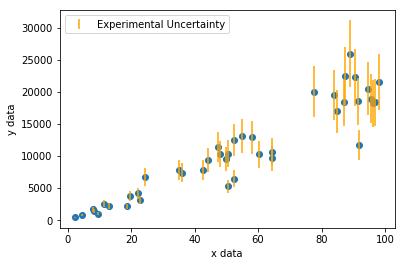

In [46]:
plt.scatter(x,y)

plt.errorbar(x,y,yerr=uncertainty,fmt='none',label='Experimental Uncertainty',color='orange')


plt.xlabel('x data')
plt.ylabel('y data')
plt.legend(loc=2)

# 1) General Approach: Curvefit with specified model (SciPy)

The advantage of knowing how to use this is that it extends to any reasonable model you please. This method will work if you need to fit an exponential or gaussian too, for example. All you need to do is create a model as a function of input, like x, and a set of parameters.

ex: model(x,p1,p2,p3,...,pn)

Once this is specified, you tell optimize.curve_fit what your model is, as well as which x and y data it needs to fit to. If your model is any more complicated than a linear model, you should specify a guess for what the optimal parameters are as well to assist the model in converging. We'll look at an example of this later.

In [119]:
def linear(x,m,b):
    return m*x + b

In [120]:
params, cov = optimize.curve_fit(linear,xdata=x,ydata=y)

error_on_params = np.sqrt(np.diagonal(cov))

params, error_on_params

(array([ 216.61817733, -658.17956687]), array([ 12.7020236, 784.4989699]))

You will get back your model parameters and a covariance matrix for your parameters, which you use to determine the statistical error on your parameters.

In [121]:
print('The slope, m, is '+ str(params[0]) +' +/- ' + str(error_on_params[0]) +'.') 

print('The intercept, b, is ' + str(params[1]) + ' +/- ' + str(error_on_params[1]) + '.')

The slope, m, is 216.61817732768984 +/- 12.702023595135403.
The intercept, b, is -658.1795668707159 +/- 784.4989699000929.


#### Curvefit with weights (non-uniform uncertainty)

Say we know that our uncertainty is non-uniform. Suppose, for example, that our uncertainty is 25% of our measures value. We need to perform a weighted fit to account for the various error.

In [224]:
weightedParams, weightedCov = optimize.curve_fit(linear,xdata=x,ydata=y,sigma=uncertainty,absolute_sigma=True)

error_on_weightedParams = np.sqrt(np.diagonal(weightedCov))

weightedParams, error_on_weightedParams

(array([174.46599815, -32.98084895]), array([ 6.70917002, 80.59222165]))

In [225]:
print('The slope, m, is '+ str(weightedParams[0]) +' +/- ' + str(error_on_weightedParams[0]) +'.') 

print('The intercept, b, is ' + str(weightedParams[1]) + ' +/- ' + str(error_on_weightedParams[1]) + '.')

The slope, m, is 174.4659981547259 +/- 6.709170023962702.
The intercept, b, is -32.980848947547884 +/- 80.59222164511817.


# 2) Using stats' linear regression (SciPy)

This support a quick fit for data without using weights. The model outputs various information, including the r value, the fitted parameters, and a covariance matrix for calculating statistical error on your parameters.

In [226]:
sciFit = stats.linregress(x,y)
sciFit

LinregressResult(slope=216.61817585904015, intercept=-658.179508508154, rvalue=0.9375996859019955, pvalue=5.939964639280726e-20, stderr=12.702022012919148)

In [227]:
print(sciFit.intercept) #best fit intercept
print(sciFit.slope) #best fit intercept

print()
print(np.sqrt(np.diagonal(fitted.cov_params()))) #statistical error on intercept, slope

-658.179508508154
216.61817585904015

[784.49891697  12.70202201]


# 3) Using ordinary least squares with summary (Statsmodels)

In [228]:
x_fit = sm.add_constant(x)

fitted = sm.OLS(y,x_fit).fit()

In [229]:
fitted.params, fitted.cov_params()

(array([-658.17950851,  216.61817586]),
 array([[ 6.15438551e+05, -8.61870196e+03],
        [-8.61870196e+03,  1.61341363e+02]]))

In [230]:
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     290.8
Date:                Mon, 06 Aug 2018   Prob (F-statistic):           5.94e-20
Time:                        17:55:19   Log-Likelihood:                -388.04
No. Observations:                  42   AIC:                             780.1
Df Residuals:                      40   BIC:                             783.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -658.1795    784.499     -0.839      0.4

#### Statsmodels with weights

Defining the weight as the inverse square of the uncertainty means that points which are known with a higher degree of certainty are "trusted more" by the model, while points with large degrees of uncertainty don't impact the fit too much.

In [231]:
weight = 1/uncertainty**2

In [232]:
weighted_x_fit = sm.add_constant(x)

In [233]:
weighted_fit = sm.WLS(y, weighted_x_fit, weights=weight).fit()

In [234]:
print(weighted_fit.params)
print()
print(np.sqrt(np.diagonal(weighted_fit.cov_params())))

[-32.98083995 174.46599787]

[110.01289683   9.1583926 ]


In [235]:
print(weighted_fit.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.901
Model:                            WLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     362.9
Date:                Mon, 06 Aug 2018   Prob (F-statistic):           1.14e-21
Time:                        17:55:28   Log-Likelihood:                -379.71
No. Observations:                  42   AIC:                             763.4
Df Residuals:                      40   BIC:                             766.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -32.9808    110.013     -0.300      0.7

Go to https://www.statsmodels.org/dev/examples/notebooks/generated/wls.html for more information and examples of use.

### We've now done the linear fitting problem in 5 different ways - two with weights, three without. 

### Let's compare the results graphically.

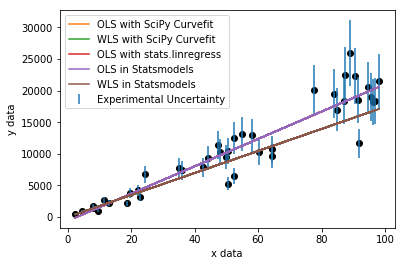

In [236]:
#scatter the raw data and its error
plt.scatter(x,y,color='black')
plt.errorbar(x,y,yerr=uncertainty,fmt='none',label='Experimental Uncertainty')


#####################################################################################################
#####################       Various fitting methods compared  #######################################
#####################################################################################################

#ordinary least squares with scipy curvefit
plt.plot(x,linear(x,*params),label='OLS with SciPy Curvefit')

#weighted least squares with scipy curvefit
plt.plot(x,linear(x,*weightedParams),label='WLS with SciPy Curvefit')

#ordinary least squares with stats.linregress
plt.plot(x,linear(x,sciFit.slope,sciFit.intercept),label='OLS with stats.linregress')

#ordinary least squares in statsmodels
plt.plot(x,linear(x,fitted.params[1],fitted.params[0]),label='OLS in Statsmodels')

#weighted least squares in statsmodels 
plt.plot(x,linear(x,weighted_fit.params[1],weighted_fit.params[0]),label='WLS in Statsmodels')



#####################################################################################################

#####################################################################################################



plt.xlabel('x data')
plt.ylabel('y data')
plt.legend()

Perhaps unsurprisingly, no matter the package used, the weighted and unweighted methods gave exactly the same solutions.

How can we quantify if our model is a good fit? There are many metrics for "goodness of fit", whether that be R^2, a reduced chi-square test, or otherwise. Since most of these models yield R^2, let's see how we'd calculate the reduced chi-square value. 

First, let's define the chi-square per degree of freedom, or reduced chi-square.

$$\frac{\chi ^{2}}{df} = \frac{1}{N-\nu}\sum_{i=1}^{N} \frac{[y_{i} - f(x_{i};\hat{\theta})]^{2}}{\sigma_{i}^{2}}$$

where $\nu$ is the number of parameters in your model (two for linear models, slope and intercept), $\sigma_{i}$ is the uncertainty in i-th measurement, $y_{i}$ is the i-th measured y value, and $f(x_{i};\hat{\theta})$ is your fitted function evaluated at the i-th x value with your fitted parameters, $\hat{\theta}$. N is, of course, the number of data points you have. Note that $N-\nu$ is what's referred to as the degrees of freedom.

Heuristically speaking, this sum is something like comparing the variance between the fitted values and the measured values with the variance that you're expecting, $\sigma_{i}^{2}$. 

Because of this, a good $\frac{\chi^{2}}{df}$ value is very close to 1. If you underestimate the uncertainty in your measurements, this statistic will be greater than 1 by a significant amount. If you overestimate the uncertainty in your measurements, the statistic will be considerably smaller than 1.

Let's now calculate each piece of this sum for a WLS example and combine them to get the reduced chi square.

In [239]:
x, y, uncertainty

(array([58.2, 77.5, 36.1, 87.5, 52.4, 11.4, 89.1,  8. ,  4.5, 47.5, 97. ,
         9.7, 94.6, 50.6, 24.4, 60.4, 18.8,  8.4, 42.8, 48.1, 35.2, 84. ,
        55.1, 19.6,  2.3, 98.2, 13. , 64.5, 91.6, 90.4, 44.3, 96.3, 64.5,
        22.3, 52.5, 87.2, 49.8, 91.8, 50.6, 95.7, 22.7, 85. ]),
 array([12900., 20019.,  7373., 22439., 12522.,  2605., 25947.,  1680.,
          873., 11400., 18386.,  1011., 20492., 10377.,  6762., 10261.,
         2142.,  1416.,  7830., 10267.,  7766., 19486., 13135.,  3837.,
          455., 21545.,  2211.,  9678., 18514., 22279.,  9388., 18198.,
        10673.,  4197.,  6461., 18375.,  9548., 11647.,  5272., 18952.,
         3097., 16945.]),
 array([2580. , 4003.8, 1474.6, 4487.8, 2504.4,  521. , 5189.4,  336. ,
         174.6, 2280. , 3677.2,  202.2, 4098.4, 2075.4, 1352.4, 2052.2,
         428.4,  283.2, 1566. , 2053.4, 1553.2, 3897.2, 2627. ,  767.4,
          91. , 4309. ,  442.2, 1935.6, 3702.8, 4455.8, 1877.6, 3639.6,
        2134.6,  839.4, 1292.2, 3675. , 

In [240]:
f = linear(x,*weightedParams)

In [241]:
numerator = (y - f)**2

In [242]:
denominator = uncertainty**2

In [243]:
dof = len(x) - len(weightedParams)
dof

40

In [244]:
np.sum(numerator/denominator)/dof

1.863377542121953

## Reduced Chi Square Goodness of Fit

In [20]:
def reducedChiSquare(observedVector, fittedVector, uncertaintyVector,numberOfParams):
    
    residuals = observedVector - fittedVector
    weightedResiduals = (residuals/uncertaintyVector)**2
    
    DoF = len(observedVector) - numberOfParams
    
    chiSq = np.sum(weightedResiduals)
    
    return chiSq/DoF

# Fitting a non-linear function

Suppose we have normally distributed data like below, and we wish to fit a Gaussian to it.

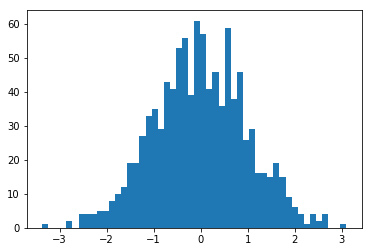

In [161]:
numBins = 50

randomValues = stats.norm.rvs(0,1,1000)
counts, bins, hist = plt.hist(randomValues,bins=numBins)

halfWidths = 0.5*(bins[1] - bins[0])
centers = bins[:-1] + halfWidths

In [162]:
def gaussian(x,a,mu,sigma):
    return a*np.exp(-.5*(x-mu)**2 / (sigma ** 2) )

Our Gaussian requires an amplitude, center, and spread, which we call a,mu, and sigma. We make guesses about what they are to use our fitting algorithm. 

A reasonable guess for this gaussian is that "a" would be the highest mark, the max amount of counts, the center would be close to the average on the x axis, and the spread would be close to the standard deviation as it normally is. 

Note that these are *guesses* and not exact solutions since this isn't a normalized Gaussian probability density, but a function of the same form.

In [163]:
parameter_guesses = [np.max(counts),np.mean(centers),np.std(centers)]

In [164]:
gaussParams, gaussCov = optimize.curve_fit(f=gaussian,xdata=centers,ydata=counts,p0=parameter_guesses)

In [165]:
gaussParams

array([ 5.21714801e+01, -2.79084754e-02,  9.90085145e-01])

The covariance matrix is $\sigma_{i}\sigma_{j}$ where i and j represent the i-th parameter in the given model. For example, the gaussian model has parameters a, mu, and sigma, corresponding to i = {1,2,3}.

The diagonal elements give the square of the uncertainty in your fit parameters,  $[\sigma_{a}^{2}, \sigma_{\mu}^{2},\sigma_{\sigma}^{2}]$.These values aren't guaranteed to be well-behaved since the procedure relies on numerical optimization, so be sure to sanity-check your results.

In [166]:
gaussCov

array([[ 2.85321344e+00, -6.54935423e-06, -3.61232425e-02],
       [-6.54935423e-06,  1.36981140e-03,  2.76038263e-07],
       [-3.61232425e-02,  2.76038263e-07,  1.37119264e-03]])

Thus the uncertainties we need can be extracted by taking the square root of the diagonal entries of the covariance matrix just like before in the linear case.

In [167]:
uncertaintyArray = np.sqrt( np.diagonal(gaussCov) )
uncertaintyArray

array([1.68914577, 0.03701096, 0.03702962])

Text(0.5,1,'Gaussian fit with error')

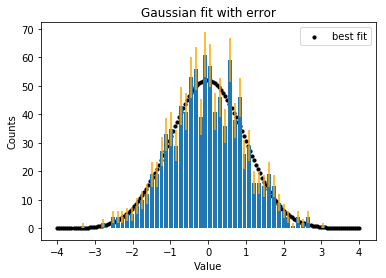

In [169]:
error= np.sqrt(counts)
plt.errorbar(centers,counts,yerr=error,fmt='none',color='orange')

_,_, hist = plt.hist(randomValues,bins=numBins,rwidth=.8)

xVals = np.linspace(-4,4,150)
plt.scatter(xVals, gaussian(xVals,*gaussParams), color='black',s=10,label='best fit')

plt.legend()
plt.ylabel('Counts')
plt.xlabel('Value')
plt.title('Gaussian fit with error')